In [64]:
import hand_seg as hs
import numpy as np
import matplotlib.pyplot as plt

segmented_letters = hs.image_segmentation('test1.png')



........Program Initiated.......


 Resizing Image........
#---------Image Info:--------#
	Height = 307 
	Width = 1320
Noise Removal
Character Segmentation

Lines : 1

Average Width of Each Letter:-  102.0


In [65]:
print(type(segmented_letters))
print(segmented_letters)

<class 'list'>
[array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8), array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8), array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8), array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, 

In [66]:
flattened_segmented_letters = [letter[0] for letter in segmented_letters]

# Now flattened_segmented_letters should be in the desired format
print(f"Total segmented images: {len(flattened_segmented_letters)}")
for idx, img in enumerate(flattened_segmented_letters):
    print(f"Segmented Image {idx} Shape: {img.shape}")

Total segmented images: 6
Segmented Image 0 Shape: (95,)
Segmented Image 1 Shape: (133,)
Segmented Image 2 Shape: (144,)
Segmented Image 3 Shape: (113,)
Segmented Image 4 Shape: (108,)
Segmented Image 5 Shape: (109,)


In [67]:
segmented_letters_normalized = [image.astype(np.float64) / 255.0 for image in segmented_letters]

Segmented Letter 1: Size = (172, 95), Type = <class 'numpy.ndarray'>
Segmented Letter 2: Size = (147, 133), Type = <class 'numpy.ndarray'>
Segmented Letter 3: Size = (130, 144), Type = <class 'numpy.ndarray'>
Segmented Letter 4: Size = (157, 113), Type = <class 'numpy.ndarray'>
Segmented Letter 5: Size = (157, 108), Type = <class 'numpy.ndarray'>
Segmented Letter 6: Size = (67, 109), Type = <class 'numpy.ndarray'>


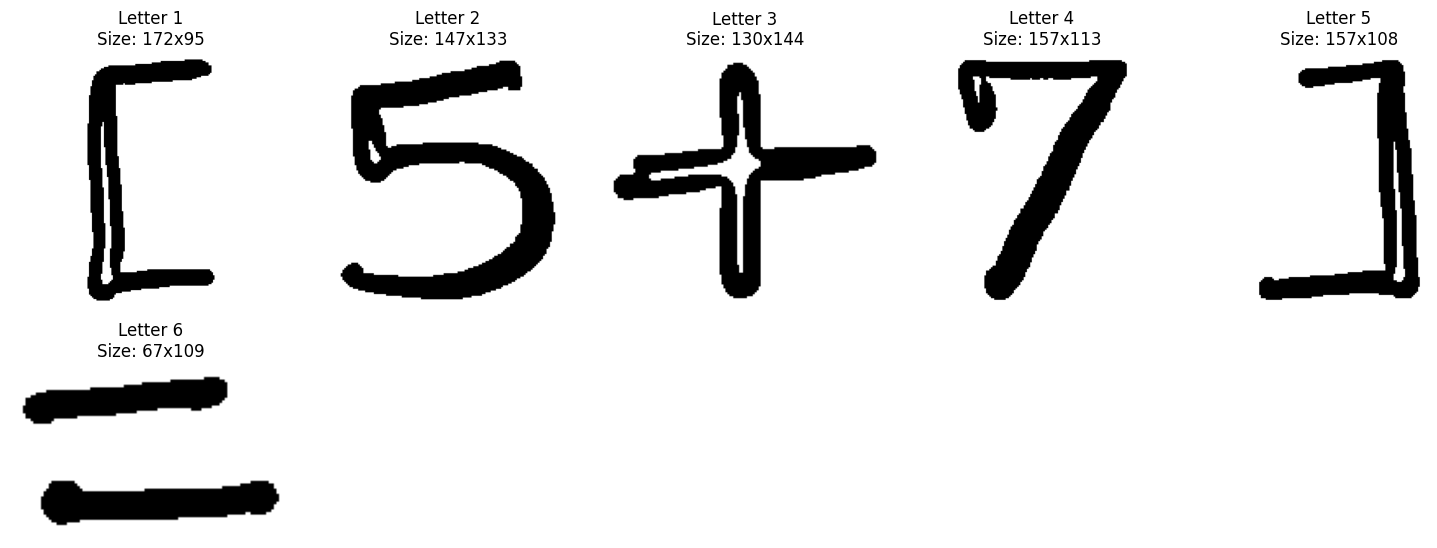

In [68]:

# Check the form and sizes of the segmented letters
letter_sizes = [letter.shape for letter in segmented_letters]  # Get sizes of each letter
letter_types = [type(letter) for letter in segmented_letters]  # Get types of each letter

# Print out the information about segmented letters
for i, (size, dtype) in enumerate(zip(letter_sizes, letter_types)):
    print(f"Segmented Letter {i + 1}: Size = {size}, Type = {dtype}")

# Plotting all segmented letters
num_letters = len(segmented_letters)
cols = 5  # Number of columns for plotting
rows = (num_letters + cols - 1) // cols  # Calculate number of rows needed

plt.figure(figsize=(15, rows * 3))
for i, letter in enumerate(segmented_letters):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(letter, cmap='gray')
    plt.axis('off')
    plt.title(f'Letter {i + 1}\nSize: {letter.shape[0]}x{letter.shape[1]}')

plt.tight_layout()
plt.show()

In [69]:
import cv2

In [70]:
# single_letter = segmented_letters[0]  # Change the index to select a different letter

# # Display the selected letter
# cv2.imshow("Segmented Letter", single_letter)
# cv2.waitKey(0)  # Wait for a key press to close the window
# cv2.destroyAllWindows()

In [71]:
# from skimage import io
# from skimage.color import rgb2gray

# # Load directly as grayscale
# image_gray_direct = io.imread('WhatsApp Image 2024-12-09 at 7.20.46 PM.jpeg', as_gray=True)

# # Load as RGB and then convert to grayscale
# image_rgb = io.imread('WhatsApp Image 2024-12-09 at 7.20.46 PM.jpeg')
# image_gray_converted = rgb2gray(image_rgb)

# # Compare shapes and values
# print("Direct Grayscale Shape:", image_gray_direct.shape)
# print("Converted Grayscale Shape:", image_gray_converted.shape)

# # Check some pixel values
# print("Direct Grayscale Pixel Value (0, 0):", image_gray_direct[0, 0])
# print("Converted Grayscale Pixel Value (0, 0):", image_gray_converted[0, 0])

In [72]:
import torch
from torch import nn
from skimage.feature import hog
from skimage.transform import resize
from skimage.io import imread
from skimage.color import rgb2gray

import numpy as np
import pickle

# Define the PolynomialSVM class
class PolynomialSVM(nn.Module):
    def __init__(self, input_dim, num_classes, degree=3):
        super(PolynomialSVM, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)
        self.degree = degree

    def forward(self, x):
        # Apply polynomial transformation
        x_poly = torch.pow(x, self.degree)
        return self.fc(x_poly)

class HingeLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(HingeLoss, self).__init__()
        self.margin = margin

    def forward(self, outputs, targets):
        targets_onehot = torch.zeros_like(outputs).scatter_(1, targets.unsqueeze(1), 1)
        hinge_loss = torch.clamp(self.margin - (outputs * targets_onehot).sum(dim=1), min=0)
        return hinge_loss.mean()

# Function to preprocess a single image (resize and extract HOG features)
def preprocess_image(image, box_size=50):
    """
    Preprocesses an input image:
    - Converts to grayscale (if not already)
    - Resizes it to box_size x box_size
    - Extracts HOG features using training parameters
    """
    try:
        # Ensure the image is grayscale
        if len(image.shape) == 3:  # If RGB, convert to grayscale
            image = np.mean(image, axis=2)

        # Resize the image to match training dimensions (box_size x box_size)
        resized_image = resize(image, (box_size, box_size), anti_aliasing=True)

      

        hog_features = hog(
        resized_image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=False,
        feature_vector=True
    )
        
        # Debugging: Print feature vector size
        print(f"Extracted Feature Vector Size: {len(hog_features)}")  # Should be 900
        
        return hog_features

    except Exception as e:
        print(f"Error during preprocessing: {e}")
        return None

# Function to test a single image
def test_single_image(image_path, model, classes):
    """
    Tests a single image using the trained SVM model:
    - Loads and preprocesses the image (resize + HOG features)
    - Predicts the class using the trained SVM model
    """
    try:
        # Load and preprocess the image
          # Load the image as RGB
        # image = imread(image_path)
# Step 2: Convert to grayscale
        # Check if the image has an alpha channel
        
        image = image_path
        print(image.shape)
        print(type(image))
        print(image)
        hog_features = preprocess_image(image)

        if hog_features is None:
            raise ValueError("Failed to extract HOG features.")

        # Convert HOG features to a PyTorch tensor and move to device
        device = next(model.parameters()).device  # Get model's device
        hog_tensor = torch.FloatTensor(hog_features).unsqueeze(0).to(device)  # Add batch dimension

        # Predict using the trained model
        with torch.no_grad():
            outputs = model(hog_tensor)
            _, predicted_class_idx = torch.max(outputs.data, 1)

        # Decode class index to class name
        predicted_class = classes[predicted_class_idx.item()]
        
        return predicted_class

    except Exception as e:
        print(f"Error during testing: {e}")
        return None

# Main testing workflow
if __name__ == "__main__":
    # Load saved classes and parameters from training
    with open('saved_features_2/hog_features.pkl', 'rb') as f:
        data = pickle.load(f)
        classes = data['classes']
        box_size = data['box_size']
        HOG_PARAMS = data['HOG_PARAMS']

    # Print training feature vector size for debugging
    print(f"Training Feature Vector Size: {len(data['X_train_hog'][0])}")  # Should be 900

    # Load trained SVM model (Polynomial or Linear)
    input_dim = len(data['X_train_hog'][0])  # Feature vector size from training data (should be 900)
    num_classes = len(classes)
    
    print("Loading trained SVM model...")
    model_path = 'best_svm_model_poly_2.pth'  # Update path if needed
    
    svm_model = PolynomialSVM(input_dim=input_dim, num_classes=num_classes, degree=3)  # Change degree if needed
    
    svm_model.load_state_dict(torch.load(model_path))
    
    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    svm_model.to(device)
    
    print("Testing on a single image...")
    
    test_image_path = 'nine_3.png' 
    for i in segmented_letters_normalized:
        test_image_path = i # Path to your test image
    
        try:
            predicted_class = test_single_image(test_image_path, svm_model, classes)
            
            if predicted_class is not None:
                print(f"Predicted Class: {predicted_class}")
        
        except Exception as e:
            print(f"Error during testing: {e}")


#####

# # Function to predict class for each segmented letter
# def predict_letters(segmented_letters, model, classes):
#     predictions = []
#     for letter in segmented_letters:
#         hog_features = preprocess_image(letter)
#         if hog_features is None:
#             predictions.append(None)  # Append None if preprocessing fails
#             continue
        
#         # Convert HOG features to a PyTorch tensor and move to device
#         device = next(model.parameters()).device  # Get model's device
#         hog_tensor = torch.FloatTensor(hog_features).unsqueeze(0).to(device)  # Add batch dimension

#         # Predict using the trained model
#         with torch.no_grad():
#             outputs = model(hog_tensor)
#             _, predicted_class_idx = torch.max(outputs.data, 1)

#         # Decode class index to class name
#         predicted_class = classes[predicted_class_idx.item()]
#         predictions.append(predicted_class)

#     return predictions

# # Main testing workflow
# if __name__ == "__main__":
#     # Load saved classes and parameters from training
#     with open('saved_features_2/hog_features.pkl', 'rb') as f:
#         data = pickle.load(f)
#         classes = data['classes']
#         box_size = data['box_size']
    
#     # Load trained SVM model (Polynomial or Linear)
#     input_dim = len(data['X_train_hog'][0])  # Feature vector size from training data (should be 900)
#     num_classes = len(classes)
    
#     print("Loading trained SVM model...")
#     model_path = 'best_svm_model_poly_2.pth'  # Update path if needed
    
#     svm_model = PolynomialSVM(input_dim=input_dim, num_classes=num_classes, degree=3)  # Change degree if needed
    
#     svm_model.load_state_dict(torch.load(model_path))
    
#     # Move model to GPU if available
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     svm_model.to(device)
    
#     print("Testing on a single image...")
    
#     test_image_path = 'test2.png'  # Path to your test image
    
#     try:
#         segmented_letters = hs.image_segmentation(test_image_path)  # Get segmented letters
        
#         predicted_classes = predict_letters(segmented_letters, svm_model, classes)  # Predict classes
        
#         for i, predicted_class in enumerate(predicted_classes):
#             print(f"Segmented Letter {i + 1}: Predicted Class: {predicted_class}")

#     except Exception as e:
#         print(f"Error during testing: {e}")



Training Feature Vector Size: 900
Loading trained SVM model...
Testing on a single image...
(172, 95)
<class 'numpy.ndarray'>
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
Extracted Feature Vector Size: 900
Predicted Class: [
(147, 133)
<class 'numpy.ndarray'>
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
Extracted Feature Vector Size: 900
Predicted Class: 5
(130, 144)
<class 'numpy.ndarray'>
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
Extracted Feature Vector Size: 900
Predicted Class: +
(157, 113)
<class 'numpy.ndarray'>
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1

C:\Users\kulka\AppData\Local\Temp\ipykernel_45496\1688673682.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  svm_model.load_state_dict(torch.load(model_path))
